# Bilaketa Lokalaren hedapenak

Bilaketa lokala, algoritmo eraginkorra den arren, sarritan motz geratzen da, eta estrategia gehigarriak inplementatzea interesgarria izaten da soluzio hobeagoak lortzeko. Dagoeneko ikusi dugu, bilaketa lokala exekutatzen dugunean, ebaluazio kopuru nahiko baldin badugu, momenturen batean, algoritmoa <b>optimo lokal</b> batean geldituko dela harrapatuta, eta posible da soluzio hori ez izatea <b>optimo globala</b>.

Aukera desberdinen artean <i>Variable Neighborhood Descent (VND)</i> algoritmoak ikusi ditugu. Notebook honetan, algoritmo hori inplementatuko dugu <i>0-1 balanced Graph Partitioning Problem (GPP)</i> ebazteko. Problema honetan, $n$ nodoko grafo bat ematen zaigu, eta nodoen arteko arkuen pisuak zehazten dituen $W=[w_{ij}]_{n\times n}$ matrizea. Helburua multzoen artean geratzen diren arkuen pisuen batura minimizatzea da. Zehazki, helburu-funtzioa $$f(x)=\sum_{i=1}^n\sum_{j=1}^n x_i\cdot (1-x_j)w_{ij}$$ ekuazioaren bitartez formalizatzen da.

eGelan, instantzien direktorioan <i>G124.16</i> instantzia utzi dizuet optimizatzeko. 

<b>Abisua</b>: orain arte ebatzi ditugun problemetan, soluzioak errepresentatzeko erabilitako kodeketak soluzio bideragarriak sortzen zituen. Adi orain!

## 0-1 Balanced Graph Partitioning Problem (GPP)

Jarraian GPParen instantzia bat irakurriko duen deia egiten da. Instantzia <i>G124.16</i> fitxategian dago gordeta.


In [81]:
import numpy as np

# GPParen instantzia diskotik irakurtzeko funtzioa
def read_instance_GPP(filepath):
    fp=open(filepath)
    line=fp.readline()
    values=line.split()
    size=int(values[0])
    W=np.zeros((size,size))
    for i in range(size):
        line=fp.readline()
        values=line.split()
        for j in range(len(values)):
            W[i][int(values[j])-1]=1
    fp.close()
    return (size,W)

instance=read_instance_GPP("Grid8x8")

Asmatu GPParen soluzioak errepresentatzeko modu bat. Jarraian, eman adibide bat.

In [82]:
import numpy as np
import random as rm

# Kodeketa bat pentsatu eta gero, proposatu errepresentazio hori duten soluziak sortzeko modu bat.
# Inplementatu horretarako funtzio bat.
def errepresentazioa(size):
    solution = np.zeros(size, dtype=int)
    perm = np.random.permutation(size)[:size//2] # lista batean permutazio bat ausaz sortu eta lista erdia hartu
    solution[perm] = 1 # sortutako indizeetan 1 jarri, honela soluzio orekatua sortzen da eta beti soluzio desberdin bat ausaz
    return solution

# Sortu ausazko soluzio bat
solution = errepresentazioa(8)
print(solution)

[1 0 0 1 0 0 1 1]


Jarraian, inplementatu soluzio bat eta GPParen instantzia bat emanik, soluzioaren helburu-balioa kalkulatu duen funtzioa.

In [83]:
# Soluzio bat emanik, bere helburu-funtzioaren balioa kalkulatuko duen funtzioa.
def objective_function_GPP(solution, instance):
    size=instance[0]
    W=instance[1]
    value=0
    for i in range(size):
        for j in range(size):
            value += solution[i]*(1-solution[j])*W[i,j] 
   
    return value

instance=read_instance_GPP("Grid8x8")
# Sortu soluzio bat. 
# BETE HEMEN (lerro 1)
solution = errepresentazioa(instance[0]) # instance[0]-rekin soluzioaren tamaina

print("Soluzioaren helburu-balioa: ",objective_function_GPP(solution,instance))

Soluzioaren helburu-balioa:  48.0


## Variable Neighborhood Search (VND)

Esan bezala VND algoritmoa erabiliko dugu GPPa ebazteko. Gogoratuko duzuen bezela, VND-ak, bilaketa lokalak ez bezala, hainbat ingurune funtzio kontsideratzen ditu. Kasu honetan, bi kontsideratuko ditugu. Bata nagusia izango da, eta bestea bigarrengoa. Algoritmoak bilaketa ingurune nagusian egingo du, eta optimo lokal batean harrapatuta geratzen den bakoitzean, bigarrengo ingurunera salto egingo du mugimendu bakarra egiteko. Bigarrengo ingurunean, hobekuntza bat egiten badu, ingurune nagusira bueltatuko da optimizatzen jarraitzeko. Aldiz, bigarrengo ingurunean ere ez badago bizilagun hoberik, orduan, uneko soluzioa bi inguruneentzako optimo lokala dela esan dezakegu, eta algoritmoa gelditu egingo da soluzioa itzuliz.

Bi ingurune funtzio proposatzen dizkizuet: <i> Hamming </i> eta <i> Insert </i> inguruneak. Baina bietako zein izango da nagusia eta zein bigarrengoa? Kasu honetan, irizpide ugari erabiltzen dira, baina ohikoena optimo lokal kopurua estimatuz jakingo dugu. Optimo lokal gutxien sortzen dituen ingurunea, ingurune nagusia izango da.

### Optimo lokalak estimatzen

Optimo lokalak estimatzeko modu sinple bat ondorengoa da. Hartu $k$ ausazko soluzio eta exekutatu bilaketa lokala optimo lokal batera iritsi arte. Aurrekoa eginez gero, $k$ optimo lokal izango ditugu. Orain, optimo lokal desberdinen portzentaia kalkulatuko dugu.

Intuizioak dio, optimo lokal gutxiko <i>landscape</i> batean, optimo lokal berdinera iristeko probabilitateak baxuagoak izango direla, eta beraz  hori ona da. Aldiz, exekuzio bakoitzean, optimo lokal desberdin batera iristen bagara, orduan <i>landscape</i>-a oso zimurra dela ondorioztatuko dugu. Zenbat eta <i>landscape</i> leunagoa, orduan eta hobeto.

Azpian inplementatu, ingurune bakoitzerako bilaketa lokaleko algoritmoak. Suposatu ez dagoela mugarik helburu-funtzio ebaluazioetan.

In [84]:
# Hamming normala eginda oreka galdu egin daiteke (1 eta 0 kantitate desberdina). Orduan, posible da amaierako soluzioa
# dena 0-z betea egotea. Kasu honetan fitness-a 0 izango zen, eta minimizazio problema bat izanik, soluzio hoberena.
# Baina, argi dago hau ez dela zuzena (0-en partizio bakarra egongo da), eta beraz, sahiestu egin beharra da oreka galtzea.

# Modu desberdinetan lortu daiteke oreka hau. Adibidez,
#  - Filtro bat erabili soluzioak sortzerakoan (adibidez %40-%60 arteko oreka lortzea). Funtzio bat erabiliz erraz egin daiteke.
#  - Swap erabili. Honela, ez dira 1 eta 0 kantitatea aldatzen. Nik hau implementatu dut ondorengo funtzioan: 
def ingurune_hamming_swap(sol):
    n = len(sol)
    for i in range(n):
        for j in range(i, n):
            if sol[i] != sol[j]: # xor(i,j). Balio berdina dutenak ez aldatu, emaitza berdina lortzen da eta.
                berria = sol.copy()
                berria[i] = sol[j]
                berria[j] = sol[i]
                
                yield berria

def local_search_hamming (instance, max_evals, sol):
    # Hasierak soluzio bat emanda hill climbing algoritmoa hamming ingurune funtzioarekin (swap kasu honetan). 
    # Aurreko laborategiko berdina.
    
    best_solution = sol
    best_fitness = objective_function_GPP(best_solution, instance)
    
    evals = 0
    hobetu_da = True
    while hobetu_da:
        hobetu_da = False
        for a in ingurune_hamming_swap(best_solution):
            if evals > max_evals:
                break
            evals += 1
            
            fitness = objective_function_GPP(a, instance)
            if fitness < best_fitness:
                besy_solution = a
                best_fitness = fitness
                hobetu_da = True 

    return (best_fitness, best_solution,max_evals)

In [129]:

# Insert ingurune fintzioarekin ere soluzio orekatuak sortuko dira. 
def ingurune_insert(sol):
    n = len(sol)
    for i in range(n):
        for j in range(i+1, n): # aurrerantz insertatzen da
            berria = np.zeros(n)
            berria[:i] = sol[:i]  # ezkerreko zatia berdin geratzen da
            berria[i:j] = sol[i+1:j+1] 
            berria[j] = sol[i] # insertatu i-ko baioa berria j posizioan
            berria[j+1:] = sol[j+1:] # indizetik pasatzen bada ez du errorea emango (j=n den kasuan)
            
            yield berria  


def local_search_insert (instance,max_evals, sol):
    # Aurrekoaren berdina, baina insert funtzioa erabiliz.
    
    best_solution = sol
    best_fitness = objective_function_GPP(best_solution, instance)
    
    hobetu_da = True
    evals = 0
    while hobetu_da:
        hobetu_da = False
        for a in ingurune_insert(best_solution):
            if evals > max_evals: # suposatu ez dagoela limitea, baina badaezpada jartzen dut
                break
            evals += 1
            
            fitness = objective_function_GPP(a, instance)
            if fitness < best_fitness:
                best_solution = a
                best_fitness = fitness
                hobetu_da = True
         
    return (best_fitness, best_solution,max_evals)          

In [130]:
# Ingurune funtzioak probatzeko
sol = errepresentazioa(4)
print("Hasierako sol: ", sol)

print("Hamming/Swap:")
for a in ingurune_hamming_swap(sol):
    print(a)

print("Insert:")
for a in ingurune_insert(sol): 
    print(a)
    
# Ikusi daiteke insert funtziok soluzio errepikatuak eman ditzazkela. Hau sahiestu daiteke kandidatu bat behin bakarrik 
# sortzek. Honek exekuzioa azkartu dezake. Baina, aldi berean, hau implementatzea bere kostua du. Ez dit denbora eman
# probatzeko, beraz dagoen bezela utzi dut.

Hasierako sol:  [0 1 0 1]
Hamming/Swap:
[1 0 0 1]
[1 1 0 0]
[0 0 1 1]
[0 1 1 0]
Insert:
[1. 0. 0. 1.]
[1. 0. 0. 1.]
[1. 0. 1. 0.]
[0. 0. 1. 1.]
[0. 0. 1. 1.]
[0. 1. 1. 0.]


In [131]:
import numpy as np

# Kalkulatu optimo lokal kopurua bilaketa espazioan. Horretarako instantzia txiki bat
# erabiliko dugu "Grid8x8" deiturikoa
k=20
instance=read_instance_GPP("Grid8x8")
max_evals=10000000
list_fitness_hamming=[]
list_fitness_insert=[]
for i in range(k):
    np.random.seed(i) # hasieran k zegoen i beharrean, eta orduan beti soluzio iguala erabiltzen zen 
                      # (eta honela beti lokal berdinean amaitzen zuen). Behin aldatuta ongi egiten du.
        
    sol = errepresentazioa(instance[0])  # hasierako soluzioa sortu, iterazio berri bakotzean desberdin bat sortuko da
    
    ls_hamming_result=local_search_hamming(instance,max_evals, sol)
    ls_insert_result=local_search_insert(instance,max_evals, sol)
    list_fitness_hamming.append(ls_hamming_result[0])
    list_fitness_insert.append(ls_insert_result[0])

print("Hamming LO:",list_fitness_hamming)
print("Insert LO:",list_fitness_insert)
print("Ratop of different local optima under Hamming: ",len(np.unique(list_fitness_hamming))/k)
print("Ratio of different local optima under Insert: ",len(np.unique(list_fitness_insert))/k)

Hamming LO: [43.0, 44.0, 52.0, 57.0, 39.0, 53.0, 55.0, 49.0, 47.0, 48.0, 49.0, 48.0, 49.0, 53.0, 56.0, 46.0, 48.0, 48.0, 37.0, 51.0]
Insert LO: [23.0, 22.0, 34.0, 37.0, 24.0, 37.0, 28.0, 25.0, 29.0, 28.0, 24.0, 35.0, 32.0, 33.0, 30.0, 22.0, 30.0, 30.0, 24.0, 29.0]
Ratop of different local optima under Hamming:  0.7
Ratio of different local optima under Insert:  0.6


Portzentaiak ikusirik, zein esango zenuke dela ingurune nagusia, eta zein bigarrena?

In [ ]:
'''
Ingurune nagusia aukeratzeko optimo lokal gutxien dituen ingurunea hartu behar da (ingurune horretan ebaluatuko da gehien,
beraz hobe optimo lokaletan ahalik eta gutxien geratzea). Beraz, ratio txikiena duen ingurunea aukeratu behar da.

Kasu honetan, Insert ingurune funtzioak ratio txikiagoa ematen du (diferentzia ez da oso handia). Horretaz gain, 
proba bakoitzean hasierako soluzio berdina erabili dute bi algorimoek, eta denatan insert-ek fitness hobea eman du.
Beraz, insert ingurune nagusia bezela aukeratuko dut, eta hamming/swap bigarren.
'''

### VND algoritmoa estimatzen

Behin aukeratuta zein izango diren erabiliko ditugun bi inguruneak, inplementatu VND algoritmoa ematen den funtzioaren definizioa erabiliz.

In [141]:
def VND_for_GPP(instance, max_evals):
    
    best_solution = errepresentazioa(instance[0])  # hasierako soluzioa
    best_fitness = objective_function_GPP(best_solution, instance)
    
    maxIter = False # ebaluazio limitera iristen denean exekuzioa amaitzeko
    evals = 0
    i = 1 # ingurune nagusiarekin hasi
    while i <= 2: # 2 ingurune funtzio
        if i == 1: 
            auzokideak = ingurune_insert(best_solution) # ingurune nagusia
        else: 
            auzokideak = ingurune_hamming_swap(best_solution) # bigarren ingurunea
           
        hoberena_ingurune = best_fitness # inguruneko soluzio hoberena lortu
        for a in auzokideak:
            if evals >= max_evals:
                maxIter = True
                break
            evals += 1 # helburu funtzioa deitzean ebaluazioa +1
            
            fitness = objective_function_GPP(a, instance)
            if (fitness < hoberena_ingurune):
                sol = a
                hoberena_ingurune = fitness
                
        if maxIter:
            break
                
        if (hoberena_ingurune < best_fitness): # hobetu bada ingurune nagusiarekin jarraitu
            best_solution = sol
            best_fitness = hoberena_ingurune
            i = 1   
        else:
            i = i + 1 # ez bada hobetu, hurrengo ingurunera pasa

    return (best_fitness, best_solution, evals)

import time as tm

#Instantzia kargatu
instance=read_instance_GPP("G124.16")

# Algoritmoa exekutatu eta kalkulatu konputorako denborak
start=tm.time()
max_evals=10000
(fitness,sol,remaining)=VND_for_GPP(instance, max_evals)
end=tm.time()

# Inprimatu balioak pantailan.
print("Best fitness solution ",fitness, sol)
print("Execution time: ",end-start)
print("Evaluations consumed: ",remaining)

Best fitness solution  586.0 [1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 1.]
Execution time:  81.32698607444763
Evaluations consumed:  10000


        n    VND
0      10  640.7
1     100  640.7
2    1000  640.7
3   10000  605.0
4  100000  527.0


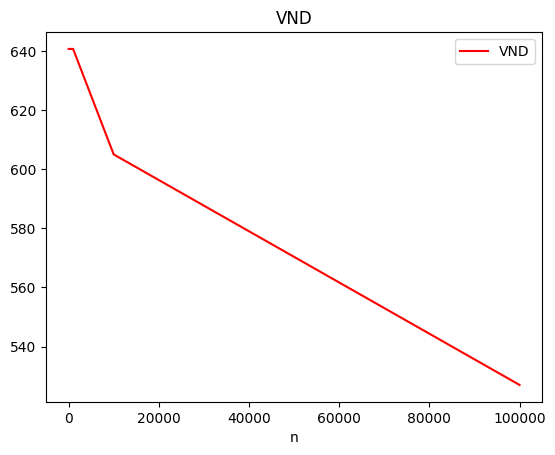

In [143]:
# VND-a ebaluazio kopuru desberdinetarako exekutatuko dugu.
# Eta grafikoa aztertuko dugu.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

list_budget = []
list_best = []
repetitions=10

#Instantzia kargatu
instance=read_instance_GPP("G124.16")

# Egin exekuzioak budget desberdinetarako: 10, 100, 1000, 10000...
for exp in range(1,6):
    budget=10**exp
    avg_fit=0
    for rep in range(repetitions):
        np.random.seed(rep)
        (fitness,sol,evals)=VND_for_GPP(instance,budget)
        avg_fit+=fitness
    avg_fit=avg_fit/repetitions
    list_budget.append(budget)
    list_best.append(avg_fit)

# Datuak gordetzeko egitura
datuak = pd.DataFrame({"n":list_budget,"VND":list_best}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='n',y='VND', color='red', ax=ax,title='VND')
plt.show()

In [ ]:
'''
Ikusi daiteke VND algoritmoa iterazio asko erabiltzeaz baliatzen dela (baina, aldi berean, denbora asko kostako zaio).
Baina, aipatzekoa da ingurune bakarra erabili dela denbora gehiengoan. Hau da, probak egiterakoan fijatu naiz ea zenbatero
ingurune nagusia optimo lokal batera iristen den eta ondoren bigarren ingurunea erabiltzen hasi den. Baina hau ez da gertatu 
n > 10000 ebaluazioetara iritsi arte. Honek esan nahi du erabili den problemak optimo lokal lokal gutxi dituela eta iterazio
asko behar izan didela optimo lokal horietako batera iristeko. Beraz, VND-ak ematen duen abantaila ez da baliatu amaierara arte.

Bestalde, n < 1000 ebaluazio gutxiegi dira problema handi honentzako, beraz, ingurune gutxi aztertzen dira eta soluzio
txar bat lortzen da optimo lokal batera iritsi gabe.

Ingurune nagusia aukeratzeko optimo lokal kantitatearen estimazioa egin beharko zen aukeran ditugun inguruneekin. Emaitza
fidagarri bat lortzeko m eta ebaluazio kantitate adierazgarria erabili beharko ziren. Baina, problema oso handia denezez, 
hainbat aldiz errepikatzeak denbora asko kostako zaio. Beraz, problema honetan ez dut estimatu lokal optimoen kantitatea.
Baina, bi moduetan probatu dut. Ondoren bien emaitzak eta hauen ondorioa aztertzen dut:

Goiko grafikan ingurune nagusia insert erabili da (hamming/swap bigarren).

Bestalde, ondorengo grafikan hamming/swap erabili da ingurune nagusia bezala (insert bigarren). 

        n    VND
0      10  640.7
1     100  640.7
2    1000  640.7
3   10000  605.4
4  100000  476.8
'''

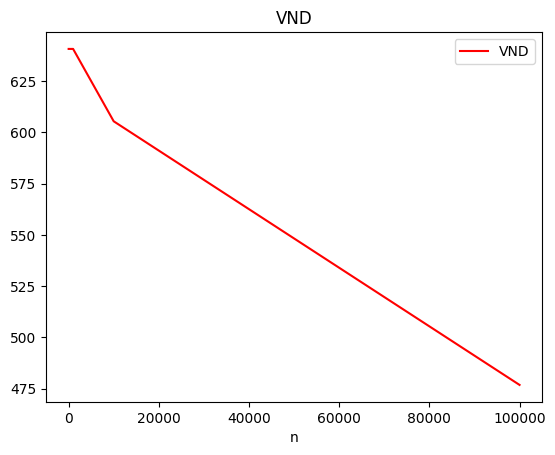

In [ ]:
'''
Ikusi daiteke hamming/swap ingurune nagusi bezela erabiltzeak batazbestekoan soluzio hobe bat ematen duela insert baino
(476.8 vs 527.0). Hau gertatzeko bi arrazoi bururatu zaizkit:

    - Hamming/swap inguruneak optimo lokal ratio txikiagoa duela problema honetan (soluzio hobe baten bilatzea errazten du
      optimo lokaletan gutxiago geratuko delako). Honen arrazoia swap egiterakoan inguruneko soluzio berriak
      jatorrizkoarekiko gutxi adatzen deirela izan daiteke. Bestalde, insert-ek sortutako soluzio berriak jatorrizkoarekiko
      asko aldatzen du, eta hori balteke problema honetarako okerragoa izatea. Jatorrikoarekiko asko aldatzeak ia ia random
      egitea bezala izango zen (ez da berdina, asko aldatzen dela adierazteko konparaketa da).
      
    - Insert inguruneak ebaluazio asko galtzen ditu auzokide errepikatuak aztertzen. Lehen aipatu den bezela, nik insert 
      funtzioa implementatu dudan moduan soluzio errepikatuak sortu daitezke. Orduan, problema handi honetan soluzio asko
      errepikatzean denbora eta ebaluazio asko galduko dira. Ondorioz, ebaluazio gutxiago egiten badira soluzio okerrago 
      batera iritsiko da (ebaluazio guztiak errepikatu gabeak izango balira soluzio hobe batera iristeko aukera gehiago izango
      zituen). Hau konpontzeko nahikoa da insert funtzioak soluzio errepikatuak ez sortzea (ez dit denbora eman egiteko; eta,
      gainera, honek bere kostua du).
'''